In [2]:
import pandas as pd
import numpy as np
import os

# read preprocessed data
cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv")
df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [4]:
df.groupby('emotion').count()

,image
emotion,
0,2665
1,1775
2,1845
3,2179
4,6396
5,5617
6,2543
7,2967


In [6]:
def get_distance(fist_point, second_point):
    distance =  math.sqrt(math.pow(fist_point[0] - second_point[0], 2) + math.pow(fist_point[1] - second_point[1], 2))
    return abs(distance)

In [11]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

error = []
mlist = []
distlist = []
eye_size_list = []
eye_brows_list = []

# run each row in train.csv
for idx, row in df.iterrows():
    imagePath = cwd + "/cleaned_images/" + row.image
    print(imagePath)
    image = cv2.imread(imagePath)

    try:
        rects = detector(image, 0)
        if len(rects) == 0:
            error.append(row.image)
            continue

        xlist = []
        ylist = []
        # loop over the face detections
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks and convert the facial landmark (x, y)
            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)

            # loop over coordinates, draw them on the image and store coordinates in two lists
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
                xlist.append(x)
                ylist.append(y)

        # get mean of both axes to determine centre of gravity
        xmean = np.mean(xlist) 
        ymean = np.mean(ylist)
        
        # plot central face on image
        cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

        # find distance between mouth
        mavg = np.mean([ylist[61] - ylist[67], ylist[62] - ylist[66], ylist[63] - ylist[65]])
        mlist.append(mavg)

        # find distance between left eye
        left_eye_avg = np.mean([
            get_distance([xlist[37], ylist[37]], [xlist[40], ylist[40]]),
            get_distance([xlist[38], ylist[38]], [xlist[41], ylist[41]])
        ])

        # find distance between right eye
        right_eye_avg = np.mean([
            get_distance([xlist[43], ylist[43]], [xlist[46], ylist[46]]),
            get_distance([xlist[44], ylist[44]], [xlist[47], ylist[47]])
        ])
        eye_size_list.append(np.mean([left_eye_avg, right_eye_avg]))

        # find distance between eye browns
        eye_brows = np.mean([ylist[24] - ylist[26], ylist[19] - ylist[17]])
        eye_brows_list.append(eye_brows)

        # find distance between every poin to central point
        templist = []
        for i in range(17, 68):
            dist = math.sqrt(math.pow(xlist[i] - xmean, 2) + math.pow(ylist[i] - ymean, 2))
            templist.append(dist)
        distavg = np.mean(dist)
        distlist.append(distavg)
    
        # show the output image with the face detections + facial landmarks
        cv2.imshow("Output", image)# 
        k = cv2.waitKey(5) & 0xFF
        if k == 68:
            break
    except:
        print(idx, row.image)
        df.drop(row.image, axis=0)
        
print(len(error))

3492 ANGER/anger (1).png


[ WARN:0@4607.029] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/pongsakorn/Desktop/Workspace/python/facial_cleandata/cleaned_images/ANGER/anger (1).png'): can't open/read file: check file path/integrity


KeyError: "['ANGER/anger (1).png'] not found in axis"

In [9]:
# add feature to df
df['mouth_distance'] = mlist
df['average_distance'] = distlist
df['eye_size'] = eye_size_list
df['eye_brows'] = eye_brows_list

df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [10]:
df

,image,emotion,mouth_distance,average_distance,eye_size,eye_brows
0,Aaron_Peirsol_0003.jpg,4,-18.666667,66.549207,19.585089,-20.5
1,Aaron_Sorkin_0001.jpg,4,-35.000000,81.688488,21.795495,-15.5
2,Aaron_Sorkin_0002.jpg,4,-28.000000,75.846449,21.333402,-25.5
3,Abbas_Kiarostami_0001.jpg,5,0.000000,51.120473,24.887785,-33.0
4,Abdel_Madi_Shabneh_0001.jpg,5,-2.666667,67.936965,25.406947,-14.0
...,...,...,...,...,...,...
4809,Zoran_Djindjic_0001.jpg,5,-2.666667,59.321605,26.089777,-23.0
4810,Zoran_Djindjic_0002.jpg,5,-20.000000,68.323791,22.514186,-17.5
4811,Zorica_Radovic_0001.jpg,5,-7.333333,78.863271,29.029678,-29.5
4812,Zulfiqar_Ahmed_0001.jpg,5,-0.666667,58.808972,17.655073,-28.5


In [11]:
from matplotlib import pyplot as plt
def scree_plot(X, n_components, with_cumulative=False, show_data_label=False, figsize=(10, 7)):
    '''
    PCA scree plot with cumulative
    '''
    scaler = StandardScaler()
    X_t=scaler.fit_transform(X)

    max_components = min(X.shape)
    x=np.arange(1, n_components+1)
    pca = PCA(n_components=max_components)
    pca.fit_transform(X_t)
    y1=pca.explained_variance_ratio_[:n_components]
    y2=np.cumsum(pca.explained_variance_ratio_)[:n_components]
    
    plt.figure(figsize=figsize)
    
    if n_components > 20:
        marker = None
    else:
        marker = 'o'
    if with_cumulative:
        plt.plot(x, y2, linestyle='--', marker=marker, label='cumulative', color='salmon')
        
    plt.plot(x, y1, linestyle='-', marker=marker, label='individual', color='deepskyblue')
    plt.title('explained variance ratio')
    plt.xlabel('Number of components')
    plt.ylabel('proportion of variance explained')
    plt.legend()
    if with_cumulative:
        [plt.axhline(y=xl, color='.7', linestyle='--') for xl in [.8, .9, .95, 1]]
    plt.grid(axis='x')

    if show_data_label:
        for n, v, cv in zip(np.nditer(x, flags=['refs_ok']), 
                            np.nditer(y1, flags=['refs_ok']),
                            np.nditer(y2, flags=['refs_ok'])):
                plt.text(n+.02, v+.02, f'{v*100:.2f}%', fontsize=10)
                if with_cumulative:
                    plt.text(n+.02, cv+.02, f'{cv*100:.2f}%', fontsize=10)

In [12]:
X = df[df.columns.difference(['Unnamed: 0', 'emotion', 'image'])]
X.corr()

,average_distance,eye_brows,eye_size,mouth_distance
average_distance,1.000000,0.271371,0.195709,-0.660873
eye_brows,0.271371,1.000000,0.047513,0.023257
eye_size,0.195709,0.047513,1.000000,0.096106
mouth_distance,-0.660873,0.023257,0.096106,1.000000


,average_distance,eye_brows,eye_size,mouth_distance
average_distance,0.716924,0.053929,-0.056292,-0.692779
eye_brows,0.258923,0.544799,0.757800,0.248782
eye_size,0.127644,0.719169,-0.639442,0.240035
mouth_distance,-0.634575,0.427880,0.116982,-0.632889


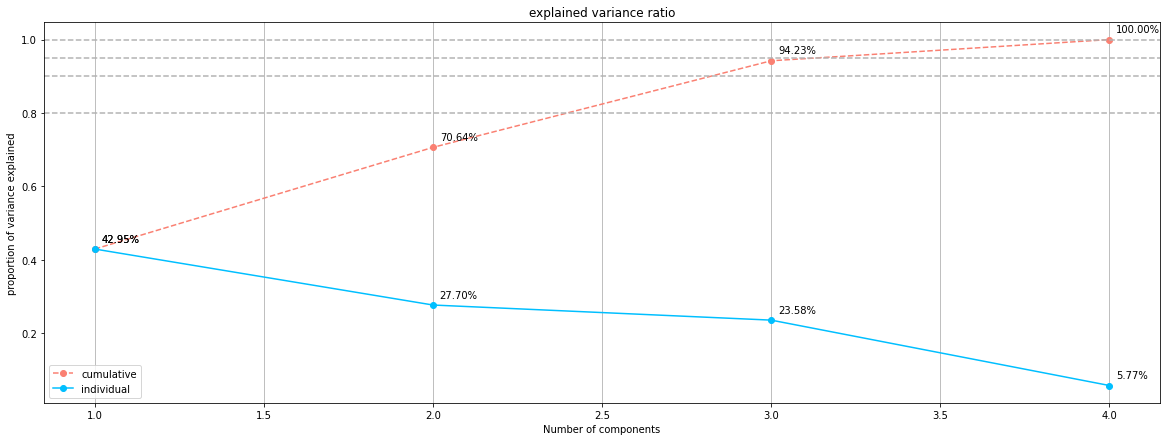

In [27]:
# Plot PCA Graph

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=4)
X_t = scaler.fit_transform(X)
pca.fit_transform(X_t)
scree_plot(X, 4, True, True, (20 , 7))
cols=['average_distance', 'eye_brows', 'eye_size', 'mouth_distance']
dpc=pd.DataFrame(pca.components_.T, 
                  index=cols, 
                  columns=X.columns)
                  
# dpc
dpc.style.applymap(lambda e: 'background-color: gray' if e > .5 else 'background-color: dark-white')

<AxesSubplot:>

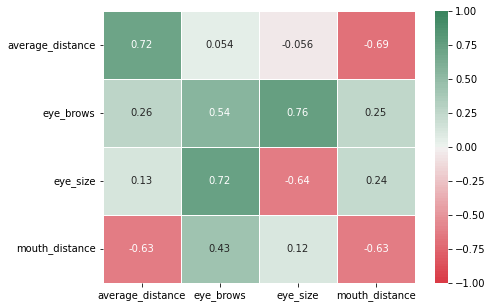

In [26]:
import seaborn as sns
dcorr=df[cols].corr()
# dcorr

mask = np.zeros_like(dcorr)
# mask.shape
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(dpc, cmap=sns.diverging_palette(10, 145, n=100), linewidths=1, 
            center=0, annot=True, vmin=-1, vmax=1)